# FIN3080 Assignment 1

> **Author Information**:
>- Name: `Weiyuan Xu`
>- StdID: `120090888`

## 0. Preparations

### 0-1. Load in packages

In [63]:
import pandas as pd
import numpy as np
import datetime as dt
import math

import seaborn as sns
from matplotlib import pyplot as plt

### 0-2. Load in datasets

#### 0-2-1. Read datasets

> **Data Resources**:
>- Data Service Platform: `CSMAR`
>- Databases: `CSMAR_China Stock Market Series` & `CSMAR_China Listed Firms Research Series`

**Detailed Selection Process of Data Tables Used:**
- table_one: China Stock Market Series -> Stock Trading -> Individual Stock Trading -> Monthly Stock Price & Returns
- table_two: China Listed Firms Research Series -> Financial Statements -> Income Statement
- table_three: China Listed Firms Research Series -> Financial Indicators -> Relative Value Index
- table_four: China Listed Firms Research Series -> Financial Statements -> Balance Sheet
- table_five: China Listed Firms Research Series -> China Listed Firm's Basic Information -> Basic Information of Listed Firm -> Yearly Statistics on Listed Firm’s Basic Information
- table_six: China Listed Firms Research Series -> Financial Statements Derivative -> Quarterly Income Statement

***Note: All above tables only include the information of A-shares with the filtering function of CSMAR***

In [64]:
table_one = pd.read_csv('1.csv')
table_two = pd.read_csv('2.csv')
table_three = pd.read_csv('3.csv')
table_four = pd.read_csv('4.csv')
table_five = pd.read_csv('5.csv')
table_six = pd.read_csv('6.csv')

#### 0-2-2. Data Cleaning and Data Processing for individual datasets

**Variables in Table 1:**
- Market Capitalization
- Stock Return
- Market Type

**Interpretation of picking corresponding tickers:**
- Market Capitalization: Use ***Total Market Value*** since these two concepts are equivalent.
- Stock Return: Use ***Monthly Return with Cash Dividend Reinvested*** to convert the quarterly return. The reason why choosing "With Cash Dividend Reinvested" is mentioned in the lecture notes: "Pratical Dividend = Adjusted Dividend = Dividend + Reinvestment", so here I choose ***Monthly Return with Cash Dividend Reinvested*** as the indicator rather than ***Monthly Return without Cash Dividend Reinvested***.
- Market Type: Use ***Market Type*** to classify different markets.

In [65]:
table_one = table_one.rename(columns={"Stkcd": "Stock_Code", "Trdmnt": "Date", "Msmvttl": "Market_Capitalization", "Mretwd": "Monthly_Return", "Markettype": "Market_Type"})
table_one.head()

,Stock_Code,Date,Market_Capitalization,Monthly_Return,Market_Type
0,1,1991-04,2118487.47,NaN,4
1,1,1991-05,1859496.56,-0.122253,4
2,1,1991-06,1648520.81,-0.113459,4
3,1,1991-07,1432695.05,-0.130921,4
4,1,1991-08,1346274.65,-0.411588,4


In [66]:
# Convert the variable type.
table_one['Quarter'] = pd.to_datetime(table_one['Date']).dt.to_period('Q')

# Compute the quarterly record.
table_one['temp_Return'] = table_one['Monthly_Return'] + 1
table_one['Return'] = table_one.groupby(['Stock_Code', 'Quarter'])['temp_Return'].cumprod() - 1

# Combine the quarterly record into a new dataframe.
df_1 = table_one.groupby(['Stock_Code', 'Quarter']).aggregate({'Market_Type': 'last', 'Market_Capitalization': 'last', 'Market_Type': 'last', 'Return': 'last'})
df_1 = df_1.reset_index()
df_1.head()

,Stock_Code,Quarter,Market_Type,Market_Capitalization,Return
0,1,1991Q2,4,1648520.81,-0.221841
1,1,1991Q3,4,1301398.82,-0.505669
2,1,1991Q4,4,2634210.72,1.024138
3,1,1992Q1,4,3508847.08,0.339450
4,1,1992Q2,4,5657258.25,0.612285


***Market Type Classification***
- Main Board: ***Market Type*** = 1, 4, 64 (Excluding whose stock code starts with 002)
- GEM Board: ***Market Type*** = 16
- SME Board: The stocks whose ***Stock Code*** starts with 002

In [67]:
# Classify by market types.
df_1["Stock_Code"] = df_1["Stock_Code"].apply(lambda x:str(x).zfill(6))

df_1.loc[df_1["Market_Type"] == 1,'Market_Type'] = 'Main'
df_1.loc[df_1["Market_Type"] == 4,'Market_Type'] = 'Main'
df_1.loc[df_1["Market_Type"] == 64,'Market_Type'] = 'Main'
df_1.loc[df_1["Market_Type"] == 16,'Market_Type'] = 'GEM'
df_1.loc[df_1["Stock_Code"].str.startswith("002"),'Market_Type'] = 'SME'

df_1["Stock_Code"] = df_1["Stock_Code"].astype('int')

df_1.head()

,Stock_Code,Quarter,Market_Type,Market_Capitalization,Return
0,1,1991Q2,Main,1648520.81,-0.221841
1,1,1991Q3,Main,1301398.82,-0.505669
2,1,1991Q4,Main,2634210.72,1.024138
3,1,1992Q1,Main,3508847.08,0.339450
4,1,1992Q2,Main,5657258.25,0.612285


**Variables in Table 2:**
- R&D Investment

**Interpretation of picking corresponding tickers:**
- R&D Investment: Use ***R&D Expense*** since these two concepts are equivalent.

***Remarks:*** 

When accessing data from CSMAR, we set the condition **"Statement Type = Consolidated Statements"** since:

Consolidated statements reflect the financial position and operating results of the entire enterprise group; 
The parent statement only reflects the business situation of the parent company, and its right to control the entire enterprise group is actually reflected in the long-term asset account as an investment. 
In the process of merging the statements of the parent company and the subsidiary company, the parent company's investment in the subsidiary company, internal purchase and sale, creditor's rights and debts are offset.

In [68]:
table_two = table_two.rename(columns={"Stkcd": "Stock_Code", "Accper": "Date", "B001216000": "R&D_Investment"})
table_two = table_two.loc[:,["Stock_Code", "Date", "R&D_Investment"]]
table_two.head()

,Stock_Code,Date,R&D_Investment
0,1,1991-12-31,NaN
1,1,1992-12-31,NaN
2,1,1993-06-30,NaN
3,1,1993-12-31,NaN
4,1,1994-06-30,NaN


***Remarks:*** 

The original data of **R&D_Investment** is cumulative in each year, in order to get the net value for each quarter in each year, we need to further do the following data processing.

In [69]:
table_two['cumulative_investment'] = table_two.groupby('Stock_Code')['R&D_Investment'].cumsum()
table_two['cumulative_investment_prev'] = table_two.groupby('Stock_Code')['cumulative_investment'].shift(1)
table_two['cumulative_investment_prev'] = table_two['cumulative_investment_prev'].fillna(0)
table_two['R&D_Investment'] = table_two['cumulative_investment'] - table_two['cumulative_investment_prev']
table_two = table_two[['Stock_Code', 'Date', 'R&D_Investment']]

In [70]:
# Convert the variable type.
table_two['Quarter'] = pd.to_datetime(table_two['Date']).dt.to_period('Q')

# Combine the quarterly record into a new dataframe.
df_2 = table_two.groupby(['Stock_Code', 'Quarter']).aggregate({'R&D_Investment': 'last'})
df_2 = df_2.reset_index()
df_2.head()

,Stock_Code,Quarter,R&D_Investment
0,1,1991Q4,NaN
1,1,1992Q4,NaN
2,1,1993Q2,NaN
3,1,1993Q4,NaN
4,1,1994Q2,NaN


**Variables in Table 3:**
- P/E Ratio
- P/B Ratio

**Interpretation of picking corresponding tickers:**
- P/E Ratio: Use ***P/E (TTM) Ratio*** since ***P/E (TTM) Ratio*** uses more recent earnings, it provides a more up-to-date picture of a company's valuation.
- P/B Ratio: Use ***P/B Ratio*** since these two concepts are equivalent.

In [71]:
table_three = table_three.rename(columns={"Stkcd": "Stock_Code", "Accper": "Date", "F100103C": "P/E_Ratio", "F100401A": "P/B_Ratio"})
table_three = table_three.loc[:,["Stock_Code", "Date", "P/E_Ratio", "P/B_Ratio"]]
table_three.head()

,Stock_Code,Date,P/E_Ratio,P/B_Ratio
0,1,1991-12-31,NaN,4.581558
1,1,1992-12-31,NaN,10.994626
2,1,1993-12-31,22.031630,5.063778
3,1,1994-06-30,NaN,2.393537
4,1,1994-12-31,12.678204,2.721719


In [72]:
# Convert the variable type.
table_three['Quarter'] = pd.to_datetime(table_three['Date']).dt.to_period('Q')

# Combine the quarterly record into a new dataframe.
df_3 = table_three.groupby(['Stock_Code', 'Quarter']).aggregate({'P/E_Ratio': 'last', 'P/B_Ratio': 'last'})
df_3 = df_3.reset_index()
df_3.head()

,Stock_Code,Quarter,P/E_Ratio,P/B_Ratio
0,1,1991Q4,NaN,4.581558
1,1,1992Q4,NaN,10.994626
2,1,1993Q4,22.031630,5.063778
3,1,1994Q2,NaN,2.393537
4,1,1994Q4,12.678204,2.721719


**Variable in Table 4:**
- Total Asset

**Interpretation of picking corresponding ticker:**
- Total Asset: Use ***Total Asset*** since these two concepts are equivalent.

***Remarks:*** 

When accessing data from CSMAR, we set the condition **"Statement Type = Consolidated Statements"** since:

Consolidated statements reflect the financial position and operating results of the entire enterprise group; 
The parent statement only reflects the business situation of the parent company, and its right to control the entire enterprise group is actually reflected in the long-term asset account as an investment. 
In the process of merging the statements of the parent company and the subsidiary company, the parent company's investment in the subsidiary company, internal purchase and sale, creditor's rights and debts are offset.

In [73]:
table_four = table_four.rename(columns={"Stkcd": "Stock_Code", "Accper": "Date", "A001000000": "Total_Asset"})
table_four = table_four.loc[:,["Stock_Code", "Date", "Total_Asset"]]
table_four.head()

,Stock_Code,Date,Total_Asset
0,1,1990-12-31,2.919190e+09
1,1,1991-12-31,4.354460e+09
2,1,1992-12-31,7.522847e+09
3,1,1993-12-31,9.337871e+09
4,1,1994-06-30,1.246595e+10


In [74]:
# Convert the variable type.
table_four['Quarter'] = pd.to_datetime(table_four['Date']).dt.to_period('Q')

# Combine the quarterly record into a new dataframe.
df_4 = table_four.groupby(['Stock_Code', 'Quarter']).aggregate({'Total_Asset': 'last'})
df_4 = df_4.reset_index()
df_4.head()

,Stock_Code,Quarter,Total_Asset
0,1,1990Q4,2.919190e+09
1,1,1991Q4,4.354460e+09
2,1,1992Q4,7.522847e+09
3,1,1993Q4,9.337871e+09
4,1,1994Q2,1.246595e+10


**Variable in Table 5:**
- Firm Age

**Interpretation of picking corresponding ticker:**
- Firm age: Use ***EstablishDate*** since the difference between ***EstablishDate*** and ***2022Q4*** can be used to derive the age of firms.

***Remarks:*** 

When accessing data from CSMAR, we set the condition **"Listing Status = Normal Listing"** since:

We are to compute firm ages at the end of 2022Q4, if we do not filter out the firms that have been delisted at that time, we would mistakenly increase the age of those delisted firms.

In [75]:
table_five = table_five.rename(columns={"Symbol": "Stock_Code", "EndDate": "Date"})
table_five = table_five.loc[:,["Stock_Code", "Date", "EstablishDate"]]
table_five.head()

,Stock_Code,Date,EstablishDate
0,1,2000-12-31,1987-12-22
1,1,2001-12-31,1987-12-22
2,1,2002-12-31,1987-12-22
3,1,2003-12-31,1987-12-22
4,1,2004-12-31,1987-12-22


In [76]:
# Convert the variable type.
table_five['Quarter'] = pd.to_datetime(table_five['Date']).dt.to_period('Q')

# Compute the firm age.
table_five["EstablishDate"] = pd.to_datetime(table_five["EstablishDate"])
table_five["Firm_Age"] = (dt.datetime(2022, 12, 31) - table_five["EstablishDate"]).astype('timedelta64[Y]')

# Combine the quarterly record into a new dataframe.
df_5 = table_five.groupby(['Stock_Code', 'Quarter']).aggregate({'Firm_Age': 'last'})
df_5 = df_5.reset_index()
df_5.head()

,Stock_Code,Quarter,Firm_Age
0,1,2000Q4,35.0
1,1,2001Q4,35.0
2,1,2002Q4,35.0
3,1,2003Q4,35.0
4,1,2004Q4,35.0


**Variable in Table 6:**
- Total Income

**Interpretation of picking corresponding tickers:**
- Total Income: Use ***Total Profit*** since these two concepts are equivalent.

***Remarks:*** 

When accessing data from CSMAR, we set the condition **"Statement Type = Consolidated Statements"** since:

Consolidated statements reflect the financial position and operating results of the entire enterprise group; 
The parent statement only reflects the business situation of the parent company, and its right to control the entire enterprise group is actually reflected in the long-term asset account as an investment. 
In the process of merging the statements of the parent company and the subsidiary company, the parent company's investment in the subsidiary company, internal purchase and sale, creditor's rights and debts are offset.

In [77]:
table_six = table_six.rename(columns={"Stkcd": "Stock_Code", "EndDate": "Date", "B001000000": "Total_Income"})
table_six = table_six.loc[:,["Stock_Code", "Date", "Total_Income"]]
table_six.head()

,Stock_Code,Date,Total_Income
0,1,2002-03-31,225689680.0
1,1,2002-06-30,160355850.0
2,1,2002-09-30,162704507.0
3,1,2002-12-31,87800392.0
4,1,2003-03-31,163662862.0


In [78]:
# Convert the variable type.
table_six['Quarter'] = pd.to_datetime(table_six['Date']).dt.to_period('Q')

# Combine the quarterly record into a new dataframe.
df_6 = table_six.groupby(['Stock_Code', 'Quarter']).aggregate({'Total_Income': 'last'})
df_6 = df_6.reset_index()
df_6.head()

,Stock_Code,Quarter,Total_Income
0,1,2002Q1,225689680.0
1,1,2002Q2,160355850.0
2,1,2002Q3,162704507.0
3,1,2002Q4,87800392.0
4,1,2003Q1,163662862.0


#### 0-2-3. Merge datasets

In [79]:
df_total = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(df_1, df_2, on=['Stock_Code', 'Quarter'], how='left'), df_3, on=['Stock_Code', 'Quarter'], how='left'), df_4, on=['Stock_Code', 'Quarter'], how='left'), df_5, on=['Stock_Code', 'Quarter'], how='left'), df_6, on=['Stock_Code', 'Quarter'], how='left')
df_total

,Stock_Code,Quarter,Market_Type,Market_Capitalization,Return,R&D_Investment,P/E_Ratio,P/B_Ratio,Total_Asset,Firm_Age,Total_Income
0,1,1991Q2,Main,1648520.81,-0.221841,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1991Q3,Main,1301398.82,-0.505669,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1991Q4,Main,2634210.72,1.024138,NaN,NaN,4.581558,4.354460e+09,NaN,NaN
3,1,1992Q1,Main,3508847.08,0.339450,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1992Q2,Main,5657258.25,0.612285,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
229118,873223,2022Q3,Main,603974.40,-0.035175,10096178.42,27.36644,1.824876,4.906200e+08,NaN,4409997.26
229119,873223,2022Q4,Main,504884.85,-0.164063,NaN,NaN,NaN,NaN,NaN,NaN
229120,873305,2022Q4,Main,453568.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229121,873339,2022Q4,Main,1103221.04,-0.149406,NaN,NaN,NaN,NaN,NaN,NaN


## Problem 1

### 1-1. Problem 1-1: Construct quarterly records of tickers for Main board, GEM board and SME board.

#### 1-1-1. Main Board

In [80]:
df_Main = df_total.loc[df_total["Market_Type"] == "Main"]
df_Main.head()

,Stock_Code,Quarter,Market_Type,Market_Capitalization,Return,R&D_Investment,P/E_Ratio,P/B_Ratio,Total_Asset,Firm_Age,Total_Income
0,1,1991Q2,Main,1648520.81,-0.221841,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1991Q3,Main,1301398.82,-0.505669,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1991Q4,Main,2634210.72,1.024138,NaN,NaN,4.581558,4.354460e+09,NaN,NaN
3,1,1992Q1,Main,3508847.08,0.339450,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1992Q2,Main,5657258.25,0.612285,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
df_Main.shape

(150718, 11)

In [82]:
df_Main["Stock_Code"].nunique()

2539

#### 1-1-2. GEM Board

In [83]:
df_GEM = df_total.loc[df_total["Market_Type"] == "GEM"]
df_GEM.head()

,Stock_Code,Quarter,Market_Type,Market_Capitalization,Return,R&D_Investment,P/E_Ratio,P/B_Ratio,Total_Asset,Firm_Age,Total_Income
93726,300001,2009Q4,GEM,5643264.0,-0.039999,NaN,67.724222,5.680494,1.082560e+09,18.0,NaN
93727,300001,2010Q1,GEM,5364040.0,-0.049479,NaN,NaN,5.316064,1.090917e+09,NaN,18327872.09
93728,300001,2010Q2,GEM,4342000.0,-0.186378,NaN,53.513282,4.327279,1.102585e+09,NaN,24676993.33
93729,300001,2010Q3,GEM,4138928.0,-0.046771,NaN,47.506637,4.004262,1.157023e+09,NaN,35563360.27
93730,300001,2010Q4,GEM,5744800.0,0.387992,NaN,50.861138,5.320852,1.236124e+09,18.0,54326733.46


In [84]:
df_GEM.shape

(30333, 11)

In [85]:
df_GEM["Stock_Code"].nunique()

1249

#### 1-1-3. SME Board

In [86]:
df_SME = df_total.loc[df_total["Market_Type"] == "SME"]
df_SME.head()

,Stock_Code,Quarter,Market_Type,Market_Capitalization,Return,R&D_Investment,P/E_Ratio,P/B_Ratio,Total_Asset,Firm_Age,Total_Income
49067,2001,2004Q2,SME,2169800.6,NaN,NaN,NaN,2.917720,1.532331e+09,NaN,NaN
49068,2001,2004Q3,SME,1867647.6,-0.139254,NaN,NaN,2.477551,1.604390e+09,NaN,8884276.90
49069,2001,2004Q4,SME,1517606.2,-0.187424,NaN,20.645916,1.995429,1.597005e+09,23.0,39145196.04
49070,2001,2005Q1,SME,1280444.6,-0.156274,NaN,NaN,1.650664,1.818968e+09,NaN,21146706.99
49071,2001,2005Q2,SME,1351137.0,0.082977,NaN,20.233100,1.771590,1.844271e+09,NaN,33508498.08


In [87]:
df_SME.shape

(44282, 11)

In [88]:
df_SME["Stock_Code"].nunique()

973

### 1-2. Problem 1-2: Provide summary statistics

#### 1-2-1. Main Board

In [89]:
df_Main.loc[:,["Market_Capitalization", "Return", "Total_Income", "R&D_Investment", "P/E_Ratio", "P/B_Ratio", "Total_Asset", "Firm_Age"]].describe()

,Market_Capitalization,Return,Total_Income,R&D_Investment,P/E_Ratio,P/B_Ratio,Total_Asset,Firm_Age
count,1.507180e+05,149791.000000,1.245930e+05,2.970000e+04,1.097100e+05,133216.000000,1.388770e+05,29425.000000
mean,1.402605e+07,0.040607,4.185091e+08,2.236618e+08,1.359308e+02,5.466236,7.514043e+10,26.124928
std,6.381189e+07,0.296222,3.538079e+09,1.048677e+09,4.911779e+03,85.916664,9.165190e+11,4.779842
min,1.653600e+03,-0.898564,-1.215140e+11,-1.602876e+07,0.000000e+00,0.000000,0.000000e+00,6.000000
25%,1.999010e+06,-0.120277,3.676691e+06,1.050316e+07,1.866089e+01,1.602674,1.250936e+09,23.000000
50%,3.920417e+06,-0.009424,3.008341e+07,3.505999e+07,3.320098e+01,2.566679,3.102716e+09,26.000000
75%,8.987208e+06,0.136763,1.264461e+08,1.122653e+08,6.491656e+01,4.240331,9.314836e+09,29.000000
max,5.013108e+09,22.052631,1.509400e+11,3.992738e+10,1.492373e+06,20452.057938,3.955066e+13,64.000000


#### 1-2-2. GEM Board

In [90]:
df_GEM.loc[:,["Market_Capitalization", "Return", "Total_Income", "R&D_Investment", "P/E_Ratio", "P/B_Ratio", "Total_Asset", "Firm_Age"]].describe()

,Market_Capitalization,Return,Total_Income,R&D_Investment,P/E_Ratio,P/B_Ratio,Total_Asset,Firm_Age
count,3.033300e+04,29906.000000,2.838200e+04,1.584300e+04,2.330000e+04,28583.000000,2.908000e+04,6476.000000
mean,8.274750e+06,0.035363,3.753798e+07,6.592100e+07,1.798153e+02,4.933204,3.176716e+09,20.435300
std,2.652814e+07,0.325358,2.559439e+08,1.792947e+08,9.878637e+03,22.989038,8.709748e+09,4.530666
min,6.867263e+04,-0.950131,-9.881884e+09,0.000000e+00,2.191506e+00,0.560147,8.862633e+07,6.000000
25%,2.655130e+06,-0.140999,5.978568e+06,1.393974e+07,3.268915e+01,2.480269,1.000934e+09,18.000000
50%,4.224800e+06,-0.024945,2.079988e+07,3.051197e+07,4.959232e+01,3.641868,1.701080e+09,20.000000
75%,7.336878e+06,0.134067,4.887669e+07,6.568063e+07,8.367275e+01,5.621745,3.126424e+09,23.000000
max,1.370541e+09,17.572457,1.061734e+10,1.057652e+10,1.501433e+06,3797.001999,5.419411e+11,41.000000


#### 1-2-3. SME Board

In [91]:
df_SME.loc[:,["Market_Capitalization", "Return", "Total_Income", "R&D_Investment", "P/E_Ratio", "P/B_Ratio", "Total_Asset", "Firm_Age"]].describe()

,Market_Capitalization,Return,Total_Income,R&D_Investment,P/E_Ratio,P/B_Ratio,Total_Asset,Firm_Age
count,4.428200e+04,43894.000000,4.267600e+04,1.584500e+04,35717.000000,42582.000000,4.330500e+04,9735.000000
mean,9.275656e+06,0.037004,7.627562e+07,1.173227e+08,131.237541,4.149197,7.966620e+09,21.788803
std,2.003945e+07,0.280176,4.490600e+08,3.386517e+08,3147.240276,40.895198,4.408407e+10,4.899690
min,1.264000e+05,-0.943182,-4.186825e+10,0.000000e+00,0.301848,0.000000,5.452158e+07,10.000000
25%,2.751289e+06,-0.122203,7.565225e+06,1.417612e+07,24.182225,1.977073,1.382079e+09,19.000000
50%,4.680551e+06,-0.010617,2.826942e+07,3.971305e+07,38.204824,2.939035,2.692945e+09,21.000000
75%,8.807608e+06,0.138614,7.762589e+07,1.030973e+08,68.103263,4.459129,5.659185e+09,24.000000
max,6.046650e+08,10.152134,1.666848e+10,1.087002e+10,420284.636251,8137.906061,2.315680e+12,55.000000


### 1-3. Problem 1-3: Compare summary statistics across different markets and discuss my findings

**Finding 1**
- ***Observation***: The median of quarterly market capitalization of Main board is smaller than that of SME board, which is abnormal. 
- ***Analysis***: There are several possible explanations:
    - There can be significant variation in market capitalization within each board.
    - Companies may move between boards as their size and financial performance changes.

**Finding 2**
- ***Observation***: The medians of quarterly returns of Main board, GEM board and SME board are all negative.
- ***Conclusion***: More stocks on Main board, GEM board and SME board have experienced losses than gains.
- ***Analysis*** There are several possible explanations:
    - Speculative trading behavior of Chinese investors may increase the volatility of stock market and then drive down the stock returns.
    - Lack of transparency and regulation in the Chinese stock market may increase market inefficiencies and distortions.

**Finding 3**
- ***Observation***: The standard variation of quarterly return of GEM board is higher that of Main board and SME board.
- ***Conclusion***: The return of GEM board is less stable than that of Main board and SME board.
- ***Analysis***: There are several possible explanations:
    - The GEM board is designed for smaller, emerging companies with a focus on technology and innovation.
    - The GEM board tends to attract more speculative investors who are looking for high-growth potential.
    - The GEM board's smaller size and liquidity can also contribute to greater volatility and instability.

**Finding 4**
- ***Observation***: The median of quarterly total asset of GEM board is significantly smaller that that of Main board and SME board.
- ***Analysis***: There are several possible explanations:
    - Most of the assets of High-Tech Companies on GEM board are intangible and difficult to quantify and be incorporated into their total assets.
    - Companies on Main board have been in operation for much longer, allowing more time for companies to grow and accumulate assets.

**Finding 5**
- ***Observation***: The median of P/E Ratio of GEM board is higher than that of Main board and SME board.
- ***Conclusion***: Generally, the stocks on GEM board enjoy higher valuation than that of Main board and SME board.
- ***Analysis***: There are several possible explanations:
    - Valuation reflects the expectation of future cash flow, companies on GEM board often have a higher growth potential compared to more established companies.
    - Valuation reflects the degree of risk, the GEM Board is perceived as a higher-risk market segment with potentially higher returns, which can attract investors looking for high-growth potential.

## 2. Problem 2

### 2-1. Problem 2-1: Plot three time-series for median P/E ratio by market type

#### 2-1-1. Data Processing

***Remarks:*** 

When initially plot the time-series data of median of P/E Ratios, it is found that there is an outlier (1600+) value in Main board.

In order to better plot the overall plot and then further investigate the trend, we drop this outlier data before plotting.

In [ ]:
df_Main["Quarter"] = pd.to_datetime(df_Main["Quarter"].astype(str))
df_GEM["Quarter"] = pd.to_datetime(df_GEM["Quarter"].astype(str))
df_SME["Quarter"] = pd.to_datetime(df_SME["Quarter"].astype(str))

medianPE_Main = df_Main.groupby("Quarter")['P/E_Ratio'].median().reset_index()
medianPE_GEM = df_GEM.groupby("Quarter")['P/E_Ratio'].median().reset_index()
medianPE_SME = df_SME.groupby("Quarter")['P/E_Ratio'].median().reset_index()

# Drop the outlier
medianPE_Main.drop(axis = 1,index = 4,inplace = True)

#### 2-1-2. Data Visualization

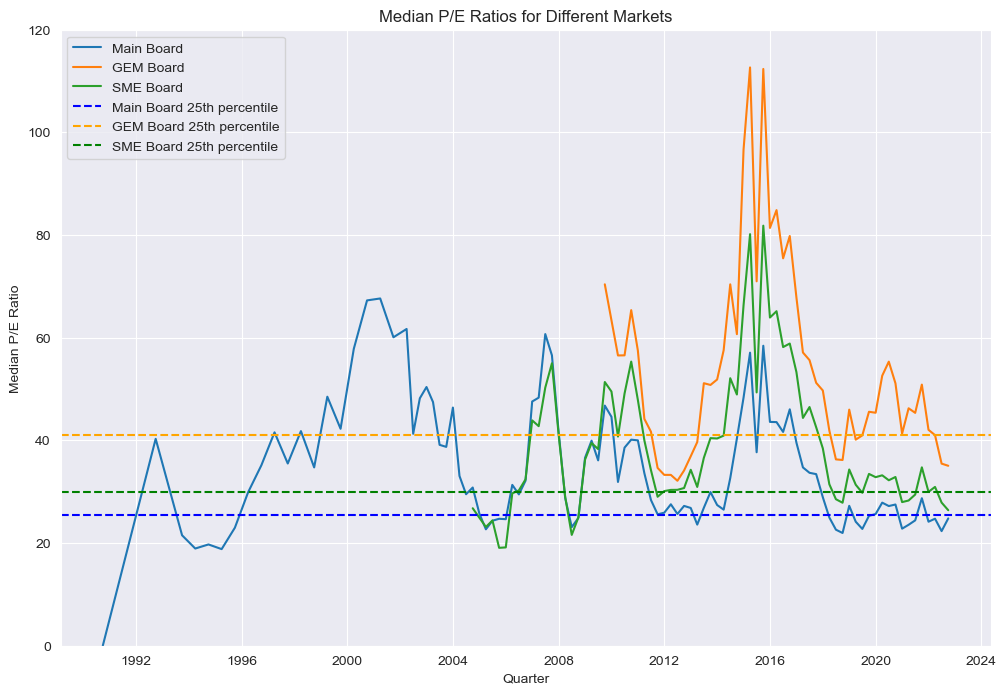

In [93]:
plt.figure(figsize = [12,8])
sns.set_style("darkgrid")

sns.lineplot(x = medianPE_Main["Quarter"], y = medianPE_Main["P/E_Ratio"], label = "Main Board")
sns.lineplot(x = medianPE_GEM["Quarter"], y = medianPE_GEM["P/E_Ratio"], label = "GEM Board")
sns.lineplot(x = medianPE_SME["Quarter"], y = medianPE_SME["P/E_Ratio"], label = "SME Board")


plt.axhline(y = medianPE_Main["P/E_Ratio"].quantile(0.25), linestyle='--', color='blue', label="Main Board 25th percentile")
plt.axhline(y = medianPE_GEM["P/E_Ratio"].quantile(0.25), linestyle='--', color='orange', label="GEM Board 25th percentile")
plt.axhline(y = medianPE_SME["P/E_Ratio"].quantile(0.25), linestyle='--', color='green', label="SME Board 25th percentile")


plt.xlabel("Quarter")
plt.ylabel("Median P/E Ratio")
plt.title("Median P/E Ratios for Different Markets")
plt.ylim(0,120)
plt.legend()

plt.show()

### 2-2. Problem 2-2: Analyze whether it is a good time to make new investments in either market as of the end of 2022

- ***Observation***: All medians of P/E Ratio of three boards are smaller than 25% of overall historical time-series data at the end of 2022.
- ***Conclusion***: The valuation of stocks on three boards are relatively low, which means most of stocks are undervalued, it is a good time to make new investments in above three markets, especially GEM board (The difference between the current median P/E Ratio and 25% of the median P/E Ratio is the largest).
- ***Analysis***: There are several possible supports for my investment strategy:
    - **Valuation**: Since the current P/E Ratio is low, then stocks are undervalued.
    - **Dividend Payment**: Since the current P/E Ratio is low, it is possible caused by high dividend rate, which will attract investors to come to invest these stocks.
    - **Reinvestment Behavior**: Since these stocks are undervalued, in order to correct prices, the firms of these stocks may buy back / do reinvestment to increase their stock price.

### 2-3. Problem 2-3: Analyze how one may make a profit by longing and shorting index ETFs that track the three markets

- ***Observation***: 
    - **Historical Trend of P/E Ratios**: The historical trends of P/E Ratios are highly similar for three markets.
    - **Short-term Future Trend of P/E Ratios**: It is found that at the end of 2022, P/E Ratio of Main board starts to increase, while P/E Ratios of GEM board and SME board remain decreasing.
- ***Conclusion***: The stock prices of Main board start to be corrected while those of GEM board and SME board does not start to be corrected yet. It is a good to make arbitrage / make a profit by **longing index ETF of GEM board and SME board and shorting index ETFs of Main board simultaneously in the short term**.
- ***Analysis***: There is a direct theoretical support for my investment strategy:
    - **Pair Trading**: Pair Trading is a good investment strategy in quantitative finance, it is simply described as "When two securities' prices are highly correlated with each other **(Here, index ETFs of three boards are highly correlated)**, we can make a profit by longing the underpriced one **(Here, the index ETF of GEM board and SME board)** and shorting the overpriced one **(Here, the index ETF of Main board)**.

## 3. Acknowledgement

- Thanks for ***Professor Jinfan ZHANG*** and ***Teaching Assistants*** for designing this assignment.
- Thanks for ***Teaching Assistants*** and ***Undergraduate Student Teaching Fellows*** for reviewing and grading this submission.

Thank you so much!